In [22]:
import zipfile
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image, ImageEnhance
import random
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
zip_path = "/content/drive/MyDrive/FODS PROJECT FOLDER/archive.zip"

extract_path = "GTS"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)

Files extracted to: GTS


In [ ]:
# zip_path = "/content/drive/MyDrive/FODS PROJECT FOLDER/archive (2).zip"
# extract_path = "CTS"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Files extracted to:", extract_path)


In [25]:
import zipfile
import os
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm

# Base directory for German dataset
german_base = "GTS"

# CSV and image paths
german_csv = os.path.join(german_base, "Train.csv")
german_img_base = os.path.join(german_base, "Train")

# Output directory for processed dataset
merged_base = "/content/german_dataset"
merged_img_dir = os.path.join(merged_base, "images")
os.makedirs(merged_img_dir, exist_ok=True)

# Load German dataset
ge_df = pd.read_csv(german_csv)
print("German CSV shape:", ge_df.shape)

# Flatten German image paths
def german_flatten_path(p):
    parts = p.split("/")
    class_id = parts[1]
    filename = parts[-1]
    new_name = f"german_{class_id}_{filename}"
    return new_name

# Create flattened filenames and relative paths
ge_df["new_filename"] = ge_df["Path"].apply(german_flatten_path)
ge_df["image_path"] = ge_df["new_filename"].apply(lambda x: os.path.join("images", x))

# Copy German images into the merged folder
print("\nCopying German dataset images...")
for old_path, new_name in tqdm(zip(ge_df["Path"], ge_df["new_filename"]), total=len(ge_df)):
    src = os.path.join(german_base, old_path)
    dst = os.path.join(merged_img_dir, new_name)
    if os.path.exists(src):
        shutil.copy(src, dst)

# Keep only required columns
ge_df = ge_df.rename(columns={"ClassId": "class"})
ge_df = ge_df[["image_path", "class"]]

# Shuffle dataset
ge_df = ge_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save final CSV
merged_csv_path = os.path.join(merged_base, "annotations_german.csv")
ge_df.to_csv(merged_csv_path, index=False)

print("\n✅ German dataset prepared successfully!")
print(f"Saved to: {merged_csv_path}")
print(f"Total images copied: {len(os.listdir(merged_img_dir))}")


German CSV shape: (39209, 8)

Copying German dataset images...


100%|██████████| 39209/39209 [00:13<00:00, 2845.30it/s]



✅ German dataset prepared successfully!
Saved to: /content/german_dataset/annotations_german.csv
Total images copied: 39209


Number of images per class:
class
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64


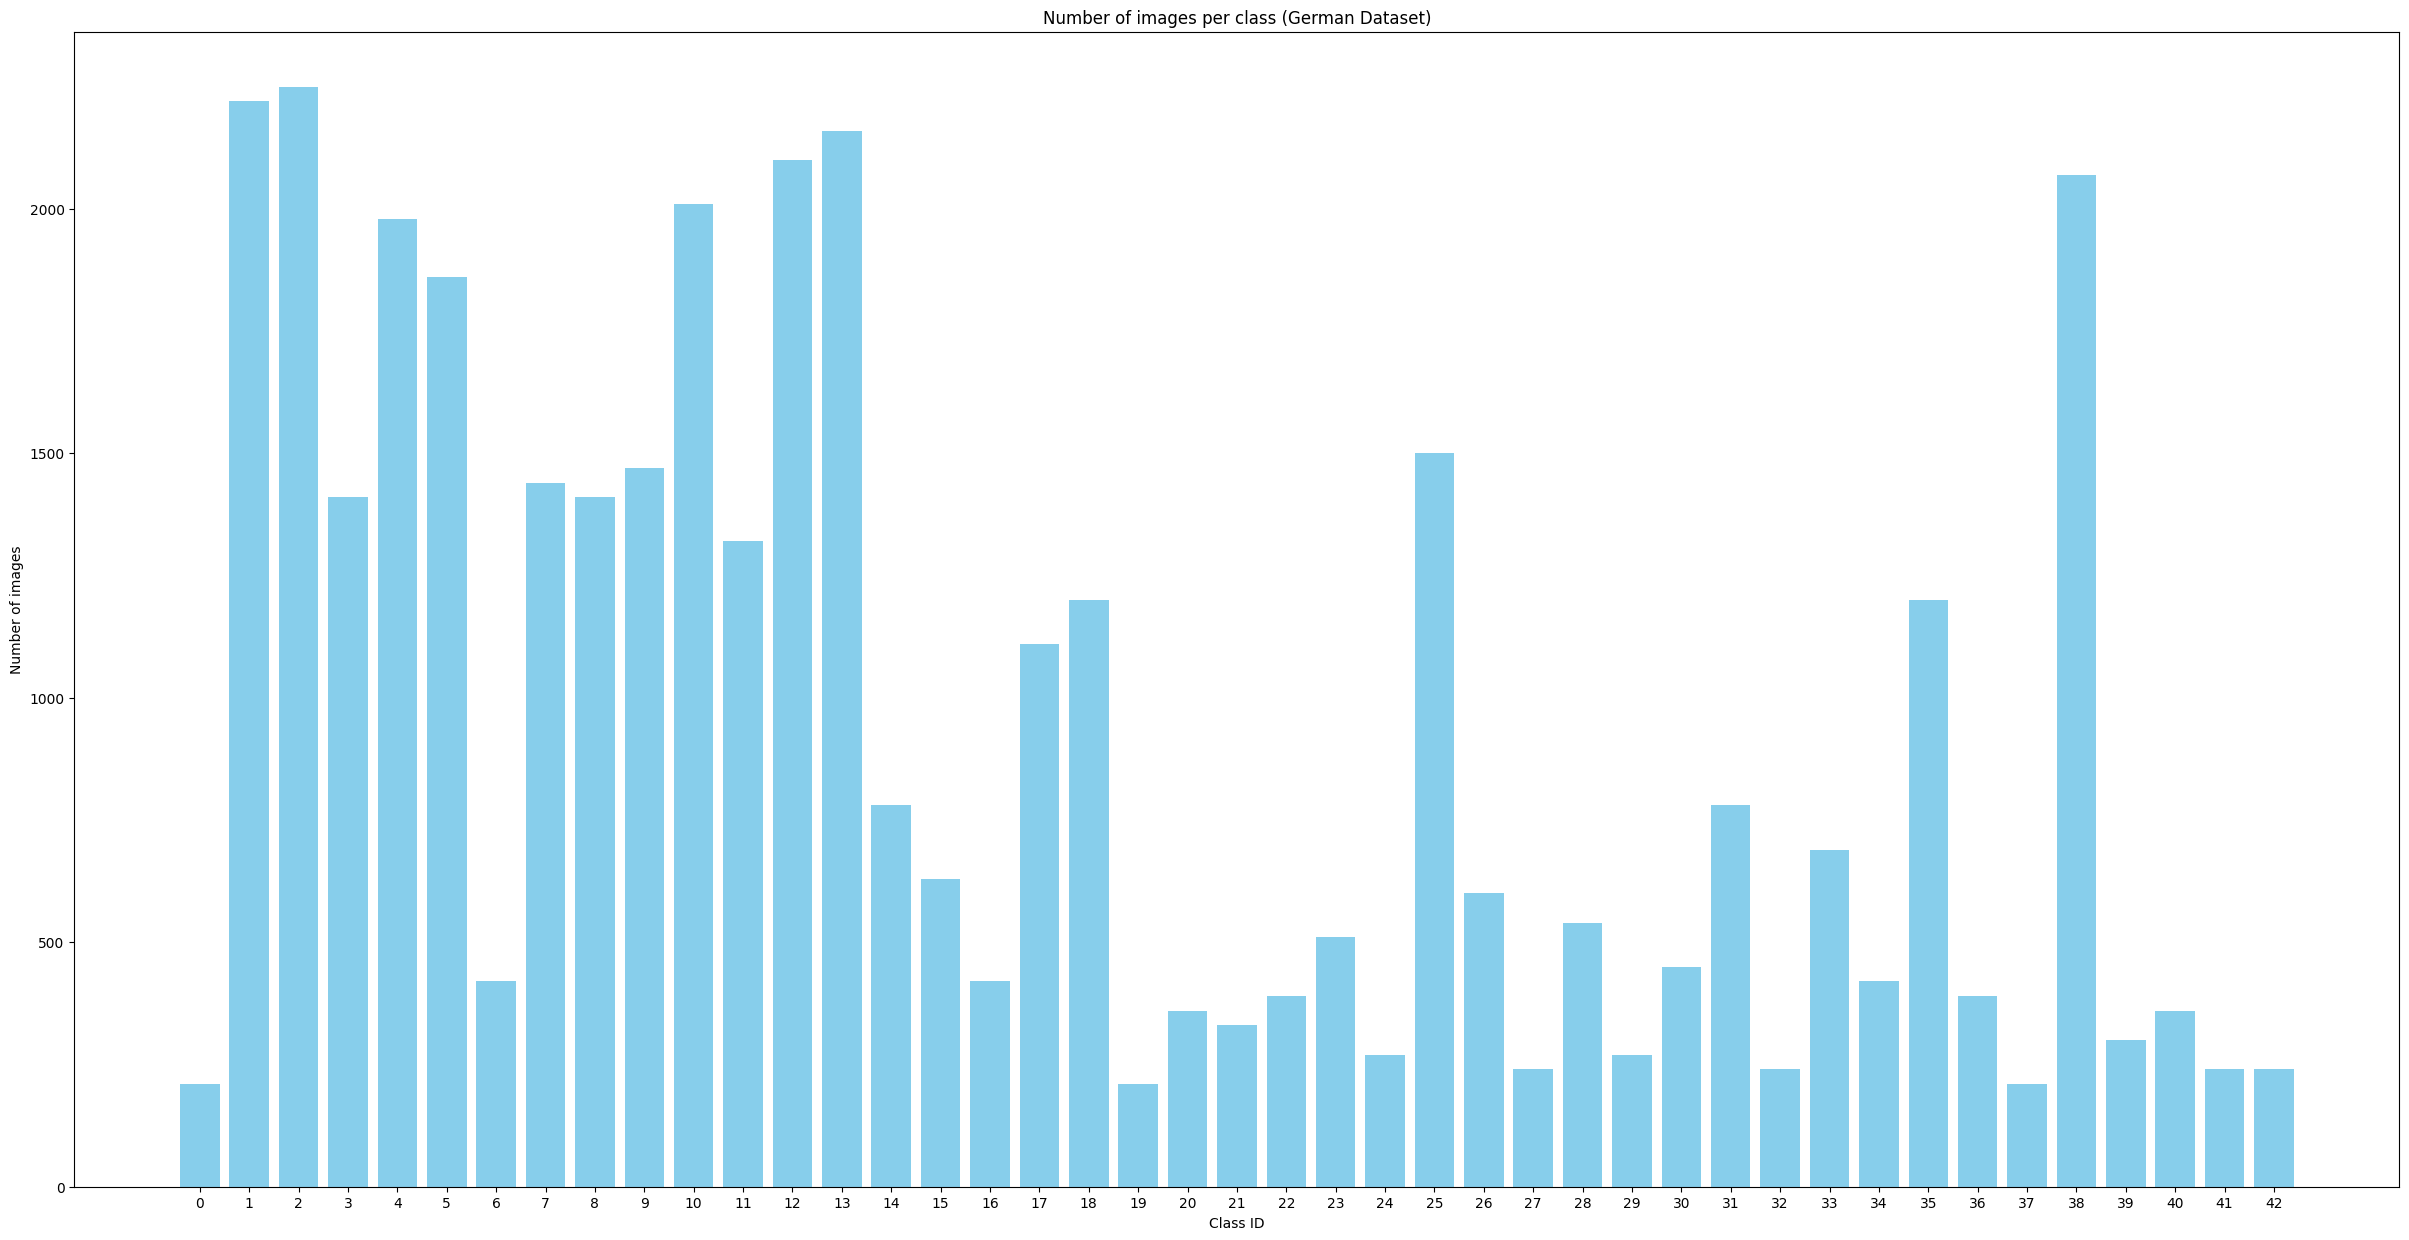

In [26]:
import matplotlib.pyplot as plt

# Assuming you've already loaded the CSV like this:
# ge_df = pd.read_csv("/content/german_dataset/annotations_german.csv")

# Number of images per class
class_counts = ge_df['class'].value_counts().sort_index()

print("Number of images per class:")
print(class_counts)

plt.figure(figsize=(30,15))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Number of images")
plt.title("Number of images per class (German Dataset)")
plt.xticks(class_counts.index)
plt.show()


In [27]:
ge_df["image_path"] = ge_df["image_path"].apply(lambda x: x.replace("images/", ""))


In [28]:
base_path = "German_TS"
image_dir = "/content/german_dataset/images"


In [29]:
import cv2
import numpy as np

def extract_traffic_sign_features(img_path):
    """
    Extracts color, shape, and edge features suitable for traffic sign classification.
    Optimized for large datasets (~47k samples).
    """
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        # Resize (small, consistent input)
        img = cv2.resize(img, (64, 64))

        # ----- 1. HSV Color Histogram -----
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist_h = cv2.calcHist([hsv], [0], None, [30], [0, 180])  # Hue
        hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256])  # Saturation
        hist_v = cv2.calcHist([hsv], [2], None, [32], [0, 256])  # Value
        color_features = np.hstack([
            cv2.normalize(hist_h, hist_h).flatten(),
            cv2.normalize(hist_s, hist_s).flatten(),
            cv2.normalize(hist_v, hist_v).flatten()
        ])

        # ----- 2. Shape descriptor (Hu Moments) -----
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        moments = cv2.moments(thresh)
        hu = cv2.HuMoments(moments).flatten()
        hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-6)  # log scale for stability

        # ----- 3. Edge features -----
        edges = cv2.Canny(gray, 100, 200)
        edge_density = np.sum(edges > 0) / edges.size

        # ----- 4. Combine all features -----
        features = np.hstack([color_features, hu, edge_density])
        return features.astype(np.float32)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None


In [30]:
X, y = [], []

# Base image directory for the German dataset
image_dir = "/content/german_dataset/images"

for idx, row in tqdm(ge_df.iterrows(), total=len(ge_df)):
    img_path = os.path.join(image_dir, os.path.basename(row['image_path']))  # full image path
    features = extract_traffic_sign_features(img_path)
    if features is not None:
        X.append(features)
        y.append(row['class'])

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


100%|██████████| 39209/39209 [00:49<00:00, 797.09it/s]

Feature matrix shape: (39209, 102)
Labels shape: (39209,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle = True
)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
model = LogisticRegression(
    class_weight='balanced',
    max_iter=2500,
    tol=1e-3,
    multi_class='ovr',
    solver='saga',
    n_jobs=-1,
    verbose=1)
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 128 epochs took 50 seconds
convergence after 350 epochs took 112 seconds
convergence after 358 epochs took 116 seconds
convergence after 362 epochs took 96 seconds
convergence after 240 epochs took 53 seconds
max_iter reached after 260 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 409 seconds
max_iter reached after 402 seconds


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


convergence after 350 epochs took 54 seconds
convergence after 350 epochs took 53 seconds
convergence after 90 epochs took 14 seconds
convergence after 178 epochs took 28 seconds
convergence after 165 epochs took 26 seconds
convergence after 88 epochs took 13 seconds
convergence after 139 epochs took 21 seconds
convergence after 191 epochs took 29 seconds
convergence after 458 epochs took 70 seconds
convergence after 1688 epochs took 259 seconds
convergence after 104 epochs took 15 seconds
convergence after 645 epochs took 100 seconds
convergence after 444 epochs took 69 seconds
convergence after 406 epochs took 64 seconds
convergence after 321 epochs took 51 seconds
convergence after 182 epochs took 28 seconds
convergence after 445 epochs took 68 seconds
convergence after 365 epochs took 56 seconds
convergence after 353 epochs took 53 seconds
convergence after 187 epochs took 29 seconds
convergence after 231 epochs took 36 seconds
convergence after 270 epochs took 42 seconds
convergen

[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed: 29.2min finished


LogisticRegression(class_weight='balanced', max_iter=2500, multi_class='ovr',
                   n_jobs=-1, solver='saga', tol=0.001, verbose=1)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.23986228003060445

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.62      0.33        42
           1       0.35      0.19      0.24       444
           2       0.33      0.12      0.18       450
           3       0.27      0.18      0.22       282
           4       0.24      0.11      0.15       396
           5       0.26      0.08      0.12       372
           6       0.65      0.58      0.62        84
           7       0.25      0.13      0.17       288
           8       0.19      0.27      0.23       282
           9       0.28      0.15      0.19       294
          10       0.32      0.21      0.25       402
          11       0.15      0.07      0.10       264
          12       0.43      0.23      0.30       420
          13       0.30      0.11      0.17       432
          14       0.44      0.67      0.53       156
          15       0.13      0.30      0.18       126
          16       0.09   

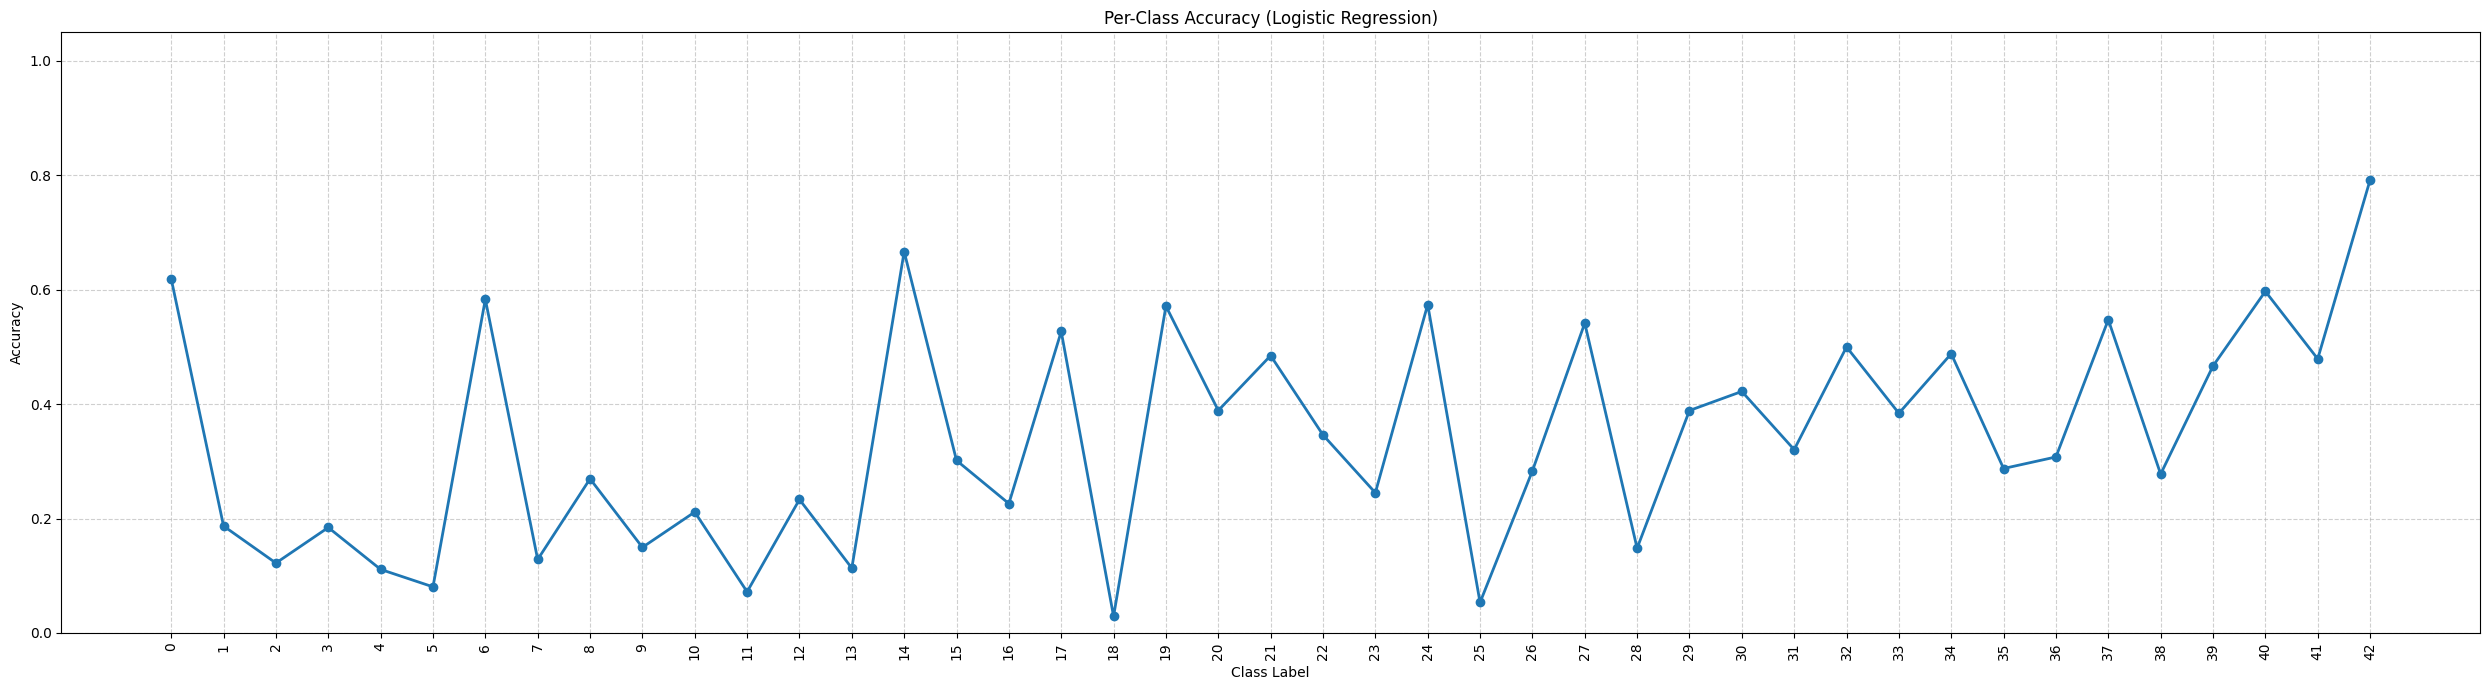

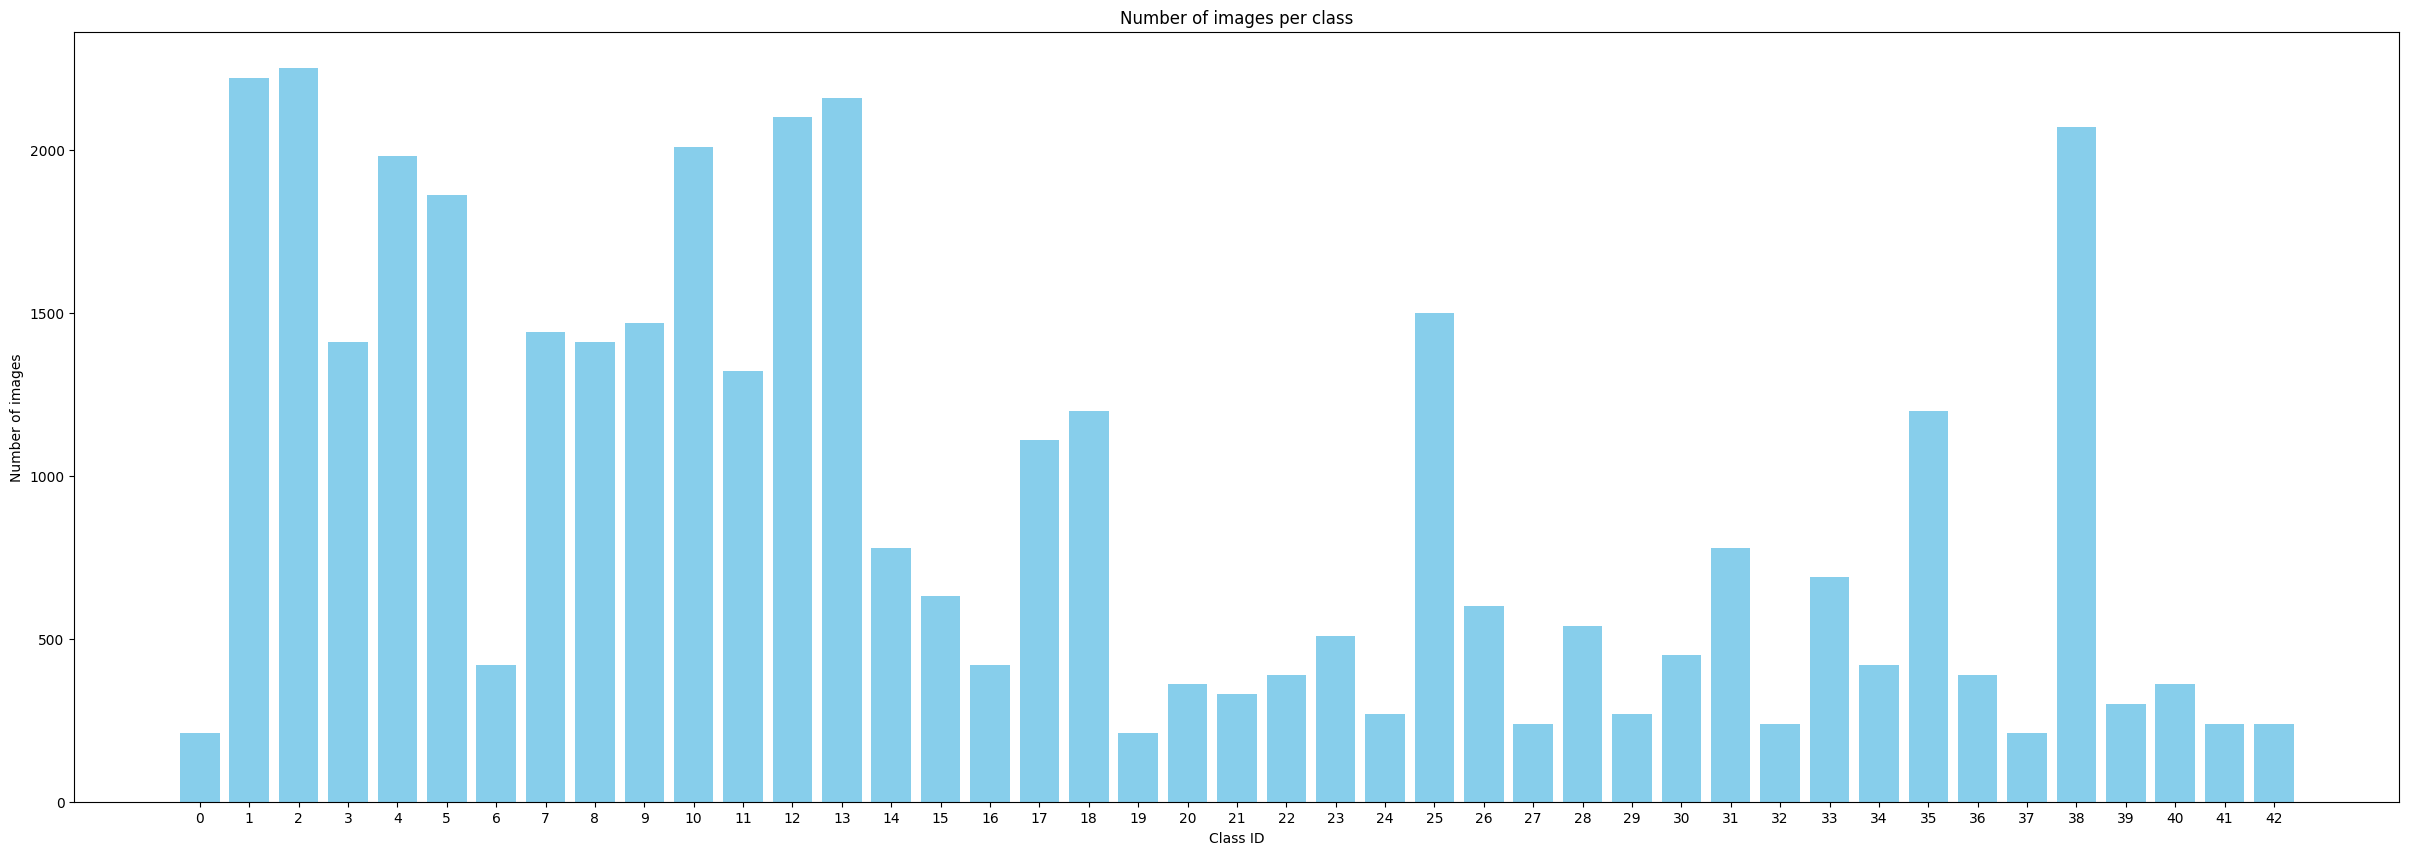

In [50]:
cm = confusion_matrix(y_test, y_pred)

# Unique classes from the original dataset
all_classes = np.arange(43)

# Computing per-class accuracy and handling cases where a class might not be in y_test
class_accuracy = np.zeros(len(all_classes))
cm_sum = cm.sum(axis=1)

# Getting unique classes present in y_test to index the confusion matrix correctly
unique_y_test_classes = np.unique(y_test)

for i, cls in enumerate(all_classes):
    if cls in unique_y_test_classes:
        # Index of the current class in the confusion matrix
        cm_index = np.where(unique_y_test_classes == cls)[0][0]
        if cm_sum[cm_index] > 0:
             class_accuracy[cls] = cm[cm_index, cm_index] / cm_sum[cm_index]
        else:
             class_accuracy[cls] = np.nan # Assign NaN if class is in y_test but has no samples
    else:
        class_accuracy[cls] = np.nan # Assign NaN if class is not in y_test


plt.figure(figsize=(25, 7))
plt.plot(all_classes, class_accuracy, marker='o', linestyle='-', linewidth=2)
plt.title("Per-Class Accuracy (Logistic Regression)")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(all_classes, rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(30,10))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Number of images")
plt.title("Number of images per class")
plt.xticks(class_counts.index)
plt.show()

In [ ]:
rf_model = RandomForestClassifier(class_weight = 'balanced', n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)



In [52]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)

class_accuracy_rf = cm_rf.diagonal() / cm_rf.sum(axis=1)
classes = np.unique(y_test)



Random Forest Accuracy: 0.9635297118082122

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.89      0.98      0.93       444
           2       0.93      0.98      0.96       450
           3       0.94      0.91      0.93       282
           4       0.95      0.94      0.95       396
           5       0.95      0.96      0.96       372
           6       1.00      0.99      0.99        84
           7       0.97      0.97      0.97       288
           8       0.99      0.96      0.97       282
           9       0.98      0.96      0.97       294
          10       0.94      0.99      0.97       402
          11       0.97      0.96      0.96       264
          12       0.98      0.99      0.98       420
          13       0.95      0.94      0.94       432
          14       0.96      0.98      0.97       156
          15       1.00      0.92      0.96       126
          16 

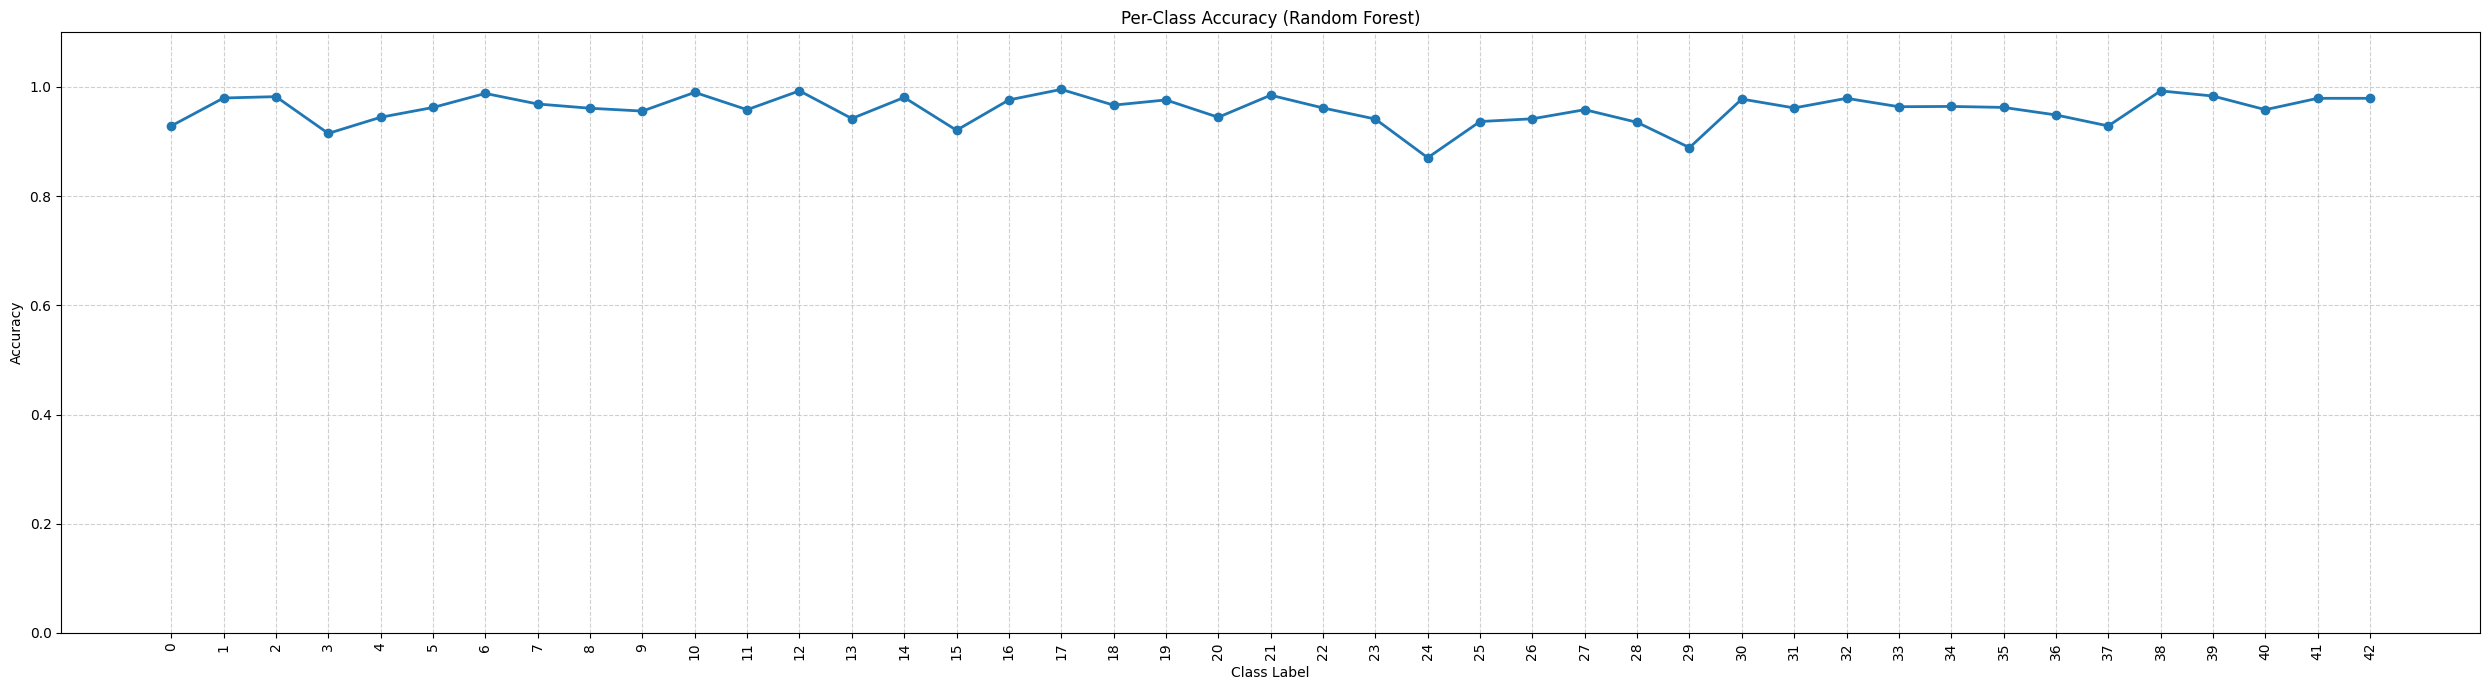

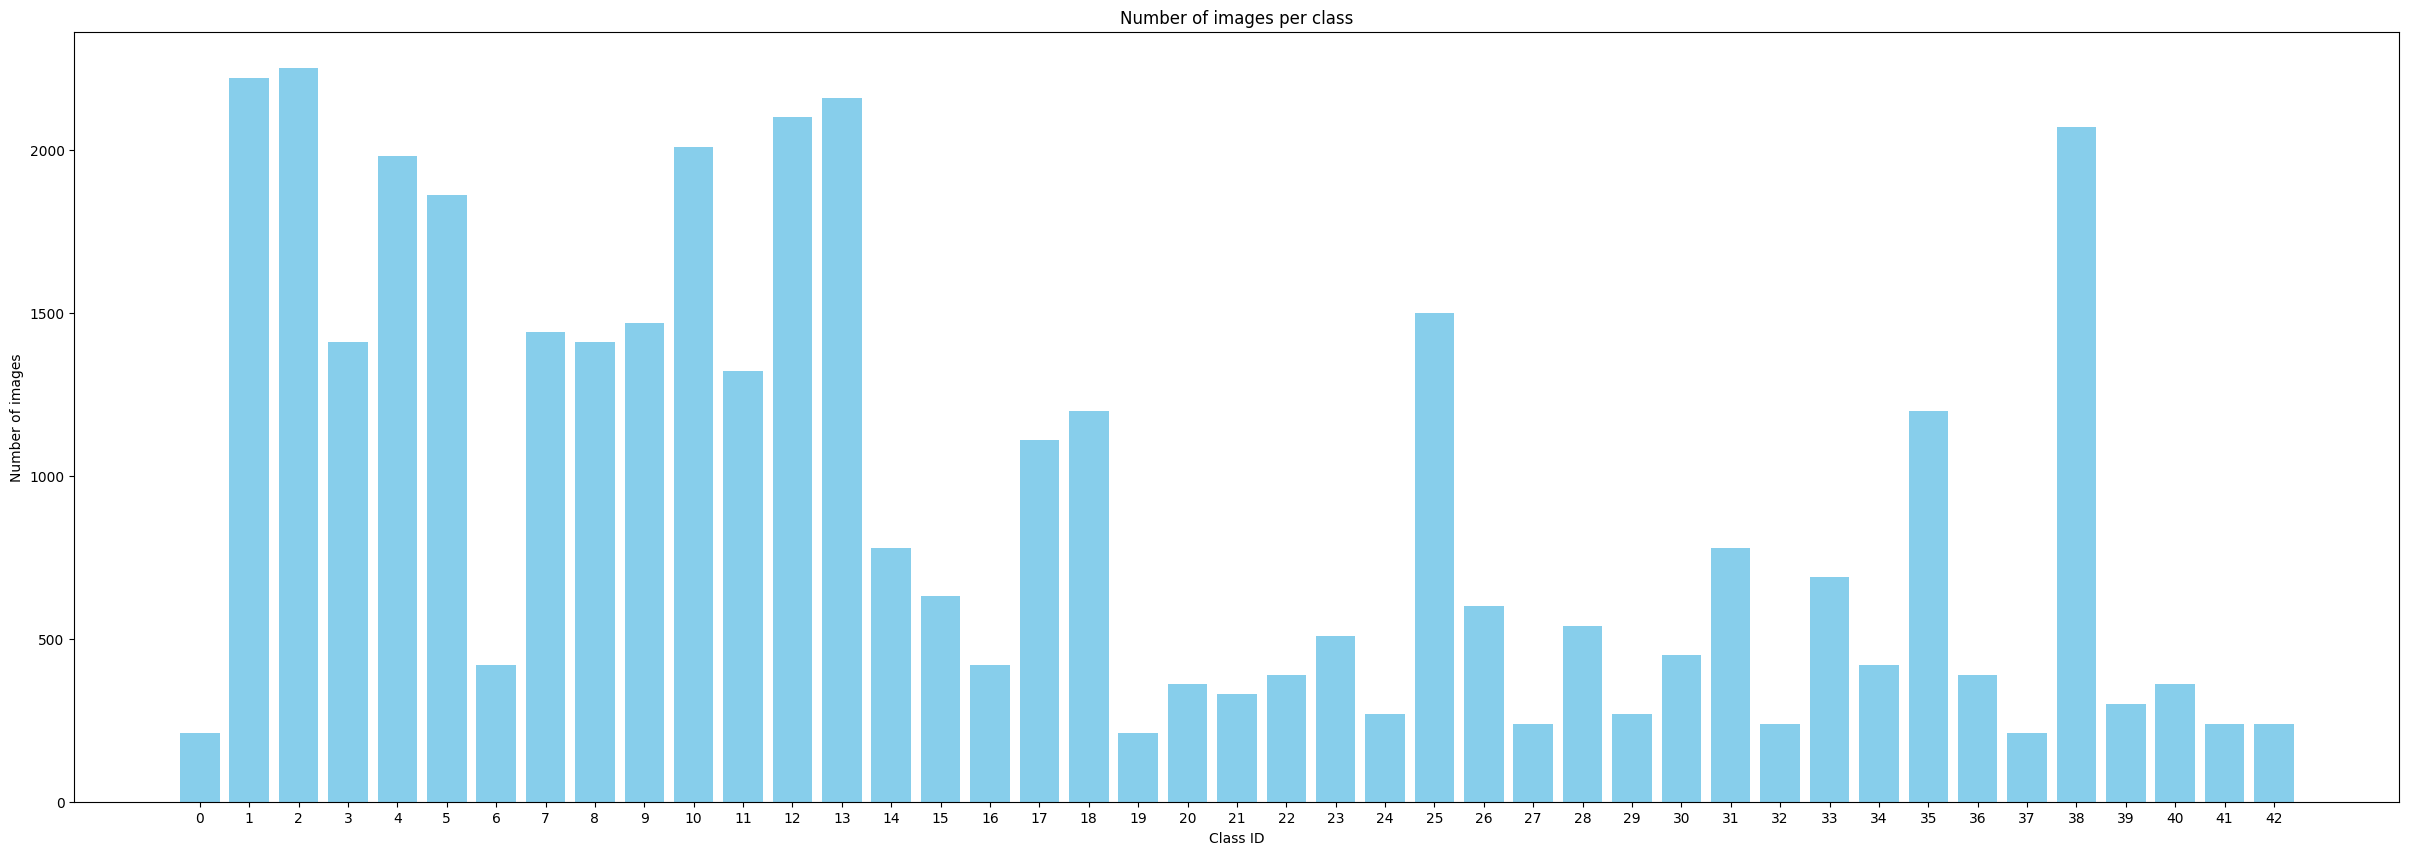

In [53]:
plt.figure(figsize=(25, 7))
plt.plot(classes, class_accuracy_rf, marker='o', linestyle='-', linewidth=2)
plt.title("Per-Class Accuracy (Random Forest)")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(all_classes, rotation=90)
plt.tight_layout()
plt.show()



plt.figure(figsize=(30,10))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Number of images")
plt.title("Number of images per class")
plt.xticks(class_counts.index)
plt.show()